In [147]:
import h5py

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import nibabel as nib
from typing import Union,Sequence

import pandas as pd
from skimage.color import label2rgb
import torch
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
import seaborn as sns
from atommic.collections.reconstruction.losses.haarpsi import haarpsi
import functools


In [148]:
dataframe_1 = pd.read_excel("/data/projects/utwente/recon/SKM-TEA_small/v1-release/predictions/MTLRS_SENSE/predictions_4x/Ensemble/2024-04-29_11-02-21/predictions/results_reconstruction_stacked_target:_False_.xlsx",sheet_name="Echo 1",index_col=0)
dataframe_2 = pd.read_excel("/data/projects/utwente/recon/SKM-TEA_small/v1-release/predictions/MTLRS_SENSE/predictions_4x/Ensemble/2024-04-29_11-02-29/predictions/results_reconstruction_stacked_target:_False_.xlsx",sheet_name="Echo 1",index_col=0)
dataframe_3 = pd.read_excel("/data/projects/utwente/recon/SKM-TEA_small/v1-release/predictions/MTLRS_SENSE/predictions_4x/Ensemble/2024-04-29_11-02-03/predictions/results_reconstruction_stacked_target:_False_.xlsx",sheet_name="Echo 1",index_col=0)

dataframe_seg_1 = pd.read_excel("/data/projects/utwente/recon/SKM-TEA_small/v1-release/predictions/MTLRS_SENSE/predictions_4x/Ensemble/2024-04-29_11-02-21/predictions/results_segmentation.xlsx",index_col=0)
dataframe_seg_2 = pd.read_excel("/data/projects/utwente/recon/SKM-TEA_small/v1-release/predictions/MTLRS_SENSE/predictions_4x/Ensemble/2024-04-29_11-02-29/predictions/results_segmentation.xlsx",index_col=0)
dataframe_seg_3 = pd.read_excel("/data/projects/utwente/recon/SKM-TEA_small/v1-release/predictions/MTLRS_SENSE/predictions_4x/Ensemble/2024-04-29_11-02-03/predictions/results_segmentation.xlsx",index_col=0)

dataframe_T2_1 = pd.read_excel("/data/projects/utwente/recon/SKM-TEA_small/v1-release/predictions/MTLRS_SENSE/predictions_4x/Ensemble/2024-04-29_11-02-29/predictions/results_T2_quantification.xlsx",index_col=0,sheet_name="Multitask T2 Estimation")
dataframe_T2_Error_1 = pd.read_excel("/data/projects/utwente/recon/SKM-TEA_small/v1-release/predictions/MTLRS_SENSE/predictions_4x/Ensemble/2024-04-29_11-02-29/predictions/results_T2_quantification.xlsx",index_col=0,sheet_name="Multitask Abs T2 Error")

dataframe_1 = dataframe_1.merge(dataframe_seg_1)
dataframe_2 = dataframe_2.merge(dataframe_seg_2)
dataframe_3 = dataframe_3.merge(dataframe_seg_3)



Text(0.5, 1.0, 'Uncertainty Plot')

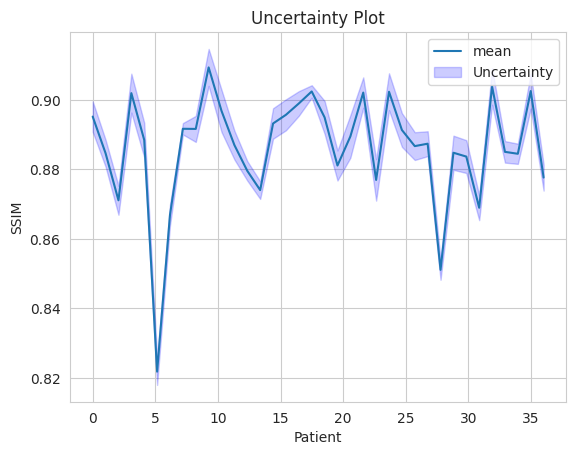

In [149]:
y_mean = []
y_std = []
for i in dataframe_1.index:
    y_mean.append(np.mean([dataframe_1.loc[i]["SSIM"],dataframe_2.loc[i]["SSIM"],dataframe_3.loc[i]["SSIM"]]))
    y_std.append(np.std([dataframe_1.loc[i]["SSIM"],dataframe_2.loc[i]["SSIM"],dataframe_3.loc[i]["SSIM"]]))
y_mean = np.array(y_mean)
y_std = np.array(y_std)
x = np.linspace(0,36,36)
plt.plot(x,y_mean,label = "mean")
plt.fill_between(x,y_mean-y_std,y_mean+y_std,color="blue",alpha=0.2,label= "Uncertainty")
plt.legend()
plt.ylabel("SSIM")
plt.xlabel("Patient")
plt.title("Uncertainty Plot")

Text(0.5, 1.0, 'Uncertainty Plot')

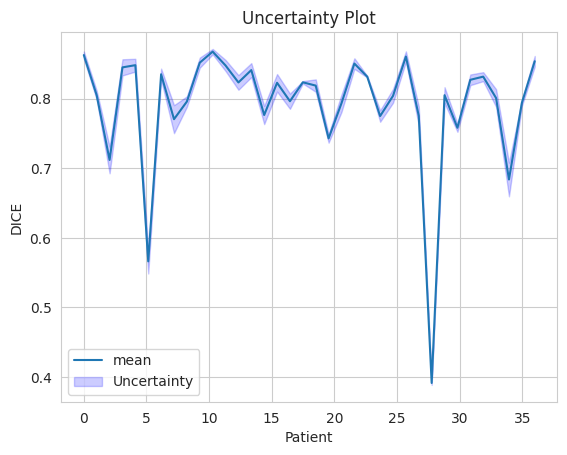

In [150]:
y_mean = []
y_std = []
for i in dataframe_1.index:
    y_mean.append(np.mean([dataframe_1.loc[i]["DICE"],dataframe_2.loc[i]["DICE"],dataframe_3.loc[i]["DICE"]]))
    y_std.append(np.std([dataframe_1.loc[i]["DICE"],dataframe_2.loc[i]["DICE"],dataframe_3.loc[i]["DICE"]]))
y_mean = np.array(y_mean)
y_std = np.array(y_std)
x = np.linspace(0,36,36)
plt.plot(x,y_mean,label = "mean")
plt.fill_between(x,y_mean-y_std,y_mean+y_std,color="blue",alpha=0.2,label= "Uncertainty")
plt.ylabel("DICE")
plt.legend()
plt.xlabel("Patient")
plt.title("Uncertainty Plot")

In [145]:
from IPython.display import display, HTML
display(dataframe_T2_1)

,id,fc,men,pc,tc
Prediction,MTR_005,31.568673,15.330890,34.214739,24.707553
Prediction,MTR_006,36.393100,17.640428,35.609425,30.306780
Prediction,MTR_030,36.838804,24.097205,32.700246,32.336525
Prediction,MTR_034,30.974238,15.941983,28.602394,24.724114
Prediction,MTR_048,31.297929,20.076362,30.239771,26.452006
Prediction,MTR_052,29.968424,21.169767,28.442177,26.039040
Prediction,MTR_065,26.950390,16.835902,29.179364,20.863364
Prediction,MTR_066,34.400172,19.541853,27.571717,27.910720
Prediction,MTR_079,31.145755,19.874851,28.920243,24.528958
Prediction,MTR_080,30.432876,17.132535,30.188899,23.522949


In [146]:
display(dataframe_T2_Error_1)

,id,fc,men,pc,tc
0,MTR_005,0.380728,0.754684,1.758208,2.150585
1,MTR_006,2.380823,4.670139,0.641448,3.565344
2,MTR_030,2.716407,6.372126,0.358107,1.209812
3,MTR_034,0.692434,1.593947,1.055353,1.389182
4,MTR_048,0.367093,0.388486,0.878516,1.804256
5,MTR_052,3.514413,3.768901,6.819256,0.728918
6,MTR_065,0.155072,0.210685,0.769526,2.432105
7,MTR_066,0.101521,0.948725,1.579807,0.466914
8,MTR_079,1.805642,2.444452,0.952857,3.100067
9,MTR_080,0.191944,0.696086,0.036535,1.981362
